<a href="https://colab.research.google.com/github/annalithell/asi-project/blob/main/dropout_bayesian_approximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dropout as a Bayesian Approximation: Reproduction of Gal & Ghahramani (2016)**

Author: Anna Lithell

# Assignment description

This assignment is a part of the course *Advanced Statistical Inference* held at EURECOM in the spring of 2025 by Dr. Simone Rossi. I've decided to reproduce the results from the paper *Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning*, published in 2016 by Gal and Ghahramani. This Jupyter notebook contains the code associated with the assignment.

🎯 Objectives
- Understand a research paper in the field of (probabilistic) machine learning.
- Be able to apply the basics of the course to reproduce the results.
- Be able to go from equations to code in a more complex setting than the labs.
- Be able to write a short report explaining the paper, the results, and the code.


## Code

This section provides the recreation of a neural network using dropout for a regression task, as described in the original paper.

**Installation and set-up**

In [30]:
# Set-up and install libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Neural Network model**

The following section defines the neural network (NN) architecture used in this experiment and follows a similar architecture as described in the paper. The model consists of four hidden layers, each with 1024 units. ReLU activations are applied after each layer to introduce non-linearity, and a dropout layer with a probability of 0.1 is used after each activation to reduce overfitting.

In [32]:
class DropoutNet(nn.Module):
    def __init__(self, input_size, hidden_size=1024, num_hidden_layers=4, dropout_prob=0.1, activation='relu'):
        super().__init__()
        act_fn = nn.ReLU() if activation == 'relu' else nn.Tanh()

        layers = [nn.Linear(input_size, hidden_size), act_fn, nn.Dropout(dropout_prob)]
        for _ in range(num_hidden_layers - 1):
            layers += [nn.Linear(hidden_size, hidden_size), act_fn, nn.Dropout(dropout_prob)]
        layers.append(nn.Linear(hidden_size, 1))  # Output layer

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

**Prepare the data set**

In this experiment, we'll train the neural network with dropout on a regression task using the california housing dataset.


In [33]:
data = fetch_california_housing(as_frame=True)
X, y = data.data, data.target

# standardize features and target
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X = scaler_x.fit_transform(X)
y = scaler_y.fit_transform(y.values.reshape(-1,1))

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

The dataset was derived from the 1990 U.S census and contains a total of 8 numeric attributes. They are:

    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

The target variable is the median house value for California districts (expressed in hundreds of thousands of dollars ($100,000)). The dataset can be visualized as follows:



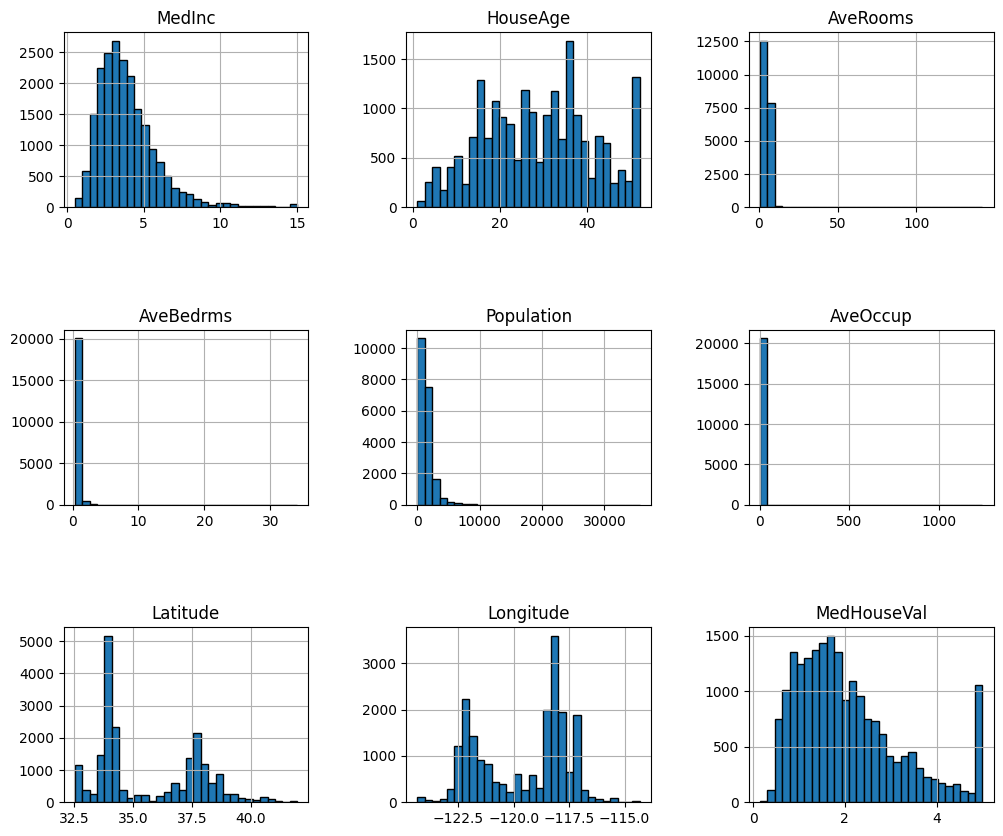

In [34]:
data.frame.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

For more information about the dataset, please visit the following [website.](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset)

**Train the network**

We'll use mini-batches of size 64 to train the network. The optimization function used when training is the Mean squared error (MSE) loss function. It is frequently used when performing regression tasks and was provided as an example loss function in the original paper.

In [35]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = DropoutNet(input_size=X_train.shape[1], dropout_prob=0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training loop
epochs = 1000
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    preds = model(X_train.to(device))
    loss = loss_fn(preds, y_train.to(device))
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.9984
Epoch 50, Loss: 0.2960
Epoch 100, Loss: 0.2321
Epoch 150, Loss: 0.2075
Epoch 200, Loss: 0.1892
Epoch 250, Loss: 0.1747
Epoch 300, Loss: 0.1624
Epoch 350, Loss: 0.1516
Epoch 400, Loss: 0.1393
Epoch 450, Loss: 0.1284
Epoch 500, Loss: 0.1189
Epoch 550, Loss: 0.1145
Epoch 600, Loss: 0.1083
Epoch 650, Loss: 0.0974
Epoch 700, Loss: 0.0917
Epoch 750, Loss: 0.0865
Epoch 800, Loss: 0.0798
Epoch 850, Loss: 0.0742
Epoch 900, Loss: 0.0716
Epoch 950, Loss: 0.0671


**Test time**

Apply Monte Carlo (MC) dropout during testing to evaluate the uncertainty of the model.

In [36]:
def predict_mc(model, data_loader, T=100):
    model.train()  # Important: keep dropout active
    device = next(model.parameters()).device
    all_predictions = []
    with torch.no_grad():
        for X_batch, _ in data_loader:
            X_batch = X_batch.to(device)
            # make multiple forward passes for each input sample
            batch_predictions = torch.stack([model(X_batch) for _ in range(T)], dim=0)
            all_predictions.append(batch_predictions)

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=1) # Concatenate along the batch dimension (dim=1)

    mean = all_predictions.mean(dim=0)
    std = all_predictions.std(dim=0)
    return mean, std

# Create test_loader
batch_size = 64 # Use same batch size as during training
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Call the modified predict_mc function with the test_loader
mean, std = predict_mc(model, test_loader, T=100)

**Visualize results and evaluate**

What is shown in the residual plot?

*  Residual = Predicted value - True value
*  It shows how much the model over or underestimate a given house price compared to the real price.
*  If residuals cluster near zero and scatter randomly, the model fits well.

What is shown in the scatter plot colored by uncertainty?

* Cool colors = low uncertainty, meaning the model is certain in its prediction
* Warm colors = high uncertainty, the model is unsure or less confident about this prediction


What does the histogram tell us?
* It displays the distribution of uncertainty values predicted by the model
* It gives us an idea if uncertainty in general is low, high or varies a lot.

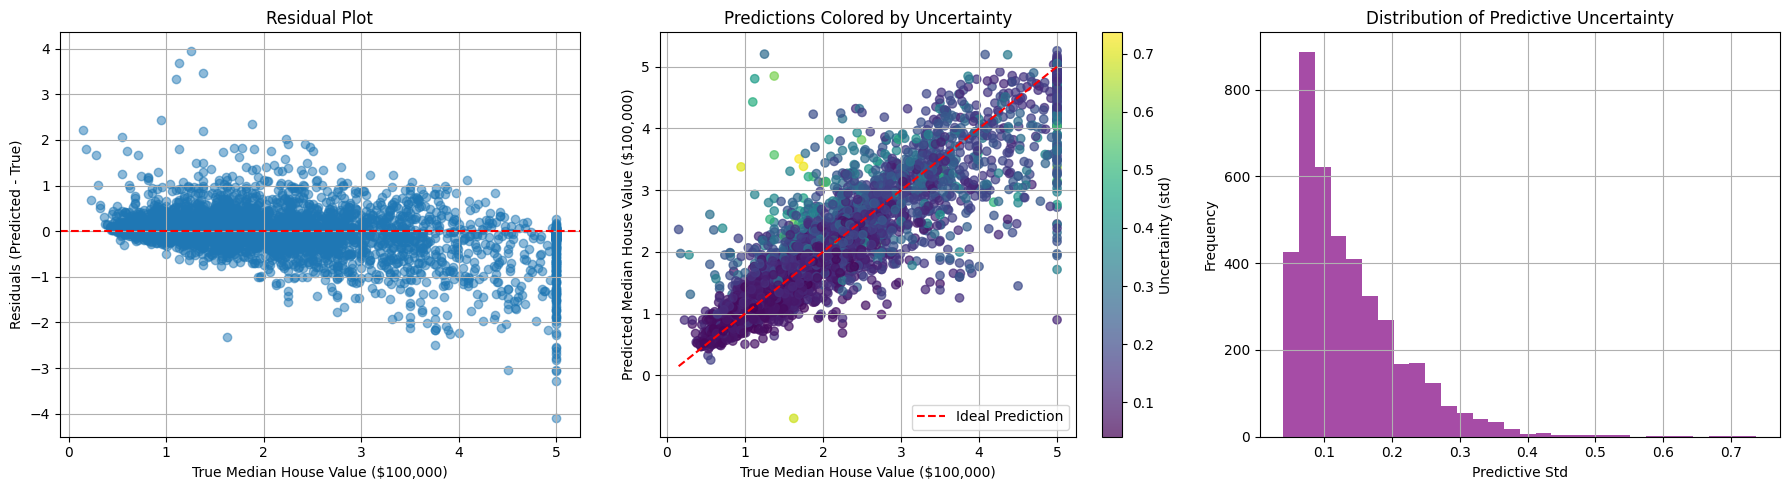

In [69]:
# Assuming these are your numpy arrays:
# y_true_np: true target values (shape [N])
# mean_np: predicted mean values (shape [N])
# std_np: predicted std (uncertainty) values (shape [N])

# Residual Plot
residuals = mean_np.squeeze() - y_true_np.squeeze()

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_true_np, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('True Median House Value ($100,000)')
plt.ylabel('Residuals (Predicted - True)')
plt.grid(True)

# Scatter plot colored by uncertainty
plt.subplot(1, 3, 2)
sc = plt.scatter(y_true_np.squeeze(), mean_np.squeeze(), c=std_np.squeeze(), cmap='viridis', alpha=0.7)
plt.colorbar(sc, label='Uncertainty (std)')
plt.plot([y_true_np.min(), y_true_np.max()],
         [y_true_np.min(), y_true_np.max()],
         'r--', label='Ideal Prediction')
plt.title('Predictions Colored by Uncertainty')
plt.xlabel('True Median House Value ($100,000)')
plt.ylabel('Predicted Median House Value ($100,000)')
plt.legend()
plt.grid(True)

# Histogram of predictive uncertainty
plt.subplot(1, 3, 3)
plt.hist(std_np.squeeze(), bins=30, alpha=0.7, color='purple')
plt.title('Distribution of Predictive Uncertainty')
plt.xlabel('Predictive Std')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

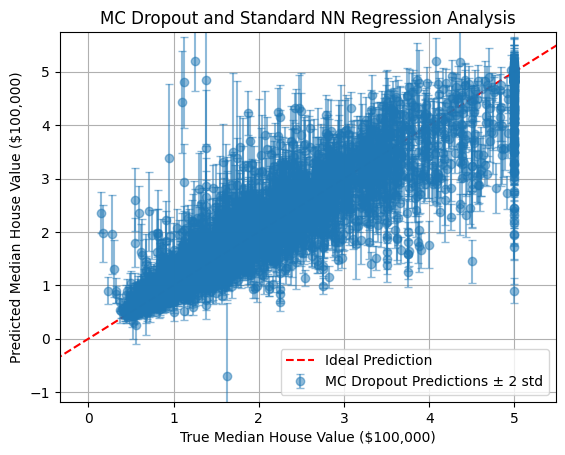

In [70]:
title = 'MC Dropout and Standard NN Regression Analysis'
xlabel = 'True Median House Value ($100,000)'
ylabel = 'Predicted Median House Value ($100,000)'

# Determine appropriate limits based on data
x_min, x_max = np.min(y_true_np), np.max(y_true_np)
y_min, y_max = mean_np.min(), mean_np.max()

# Add some padding to the limits
padding = (x_max - x_min) * 0.1
xlim = (x_min - padding, x_max + padding)
ylim = (y_min - padding, y_max + padding)

# Plot the ideal prediction line (True = Predicted)
plt.plot([min(xlim[0], ylim[0]), max(xlim[1], ylim[1])],
         [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])],
         'r--', label='Ideal Prediction')

# Plot MC Dropout predictions with uncertainty (error bars)
# Use y_true_np on the x-axis to compare predictions to true values
plt.errorbar(y_true_np.squeeze(), mean_np.squeeze(), yerr=2 * std_np,
             fmt='o', alpha=0.5, label="MC Dropout Predictions ± 2 std", capsize=3)

plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend()
plt.grid(True)
plt.show()

# Notes from the paper

## Abstract

The authors of the paper introduce the development of a new theoretical framework, casting dropout training in deep neural networks (NNs) as approximate Bayesian inference in deep Gaussian processes. Their interpretation of the results presented in the paper suggest that a model's weights can be approximately integrated by dropout.

The paper shows a considerable improvement in predictive log-likelihood and RMSE (Root Mean Square Error - determines how far predictions fall from measured true values using Euclidean distance) compared to other methods when using MNIST dataset for regression and classification tasks.

As a direct result of this theory,  it is possible  to model uncertainty with dropout NNs using existing deep learning tools as Bayesian models. This allows us to implement bayesian probability in practice without a prohibitive computational cost.

These findings are important, as standard deep learning tools for regression and classification do not capture model uncertainty, a desirable charateristic when classifying new data a model have no previous knowledge about. For example, if a model is trained exclusively on pictures of cats and dogs and is then presented with a picture of an ostrich, we want the model to produce a result stating a low probability of the ostrich being a cat or dog.


## Introduction

Problems with standard deep learning tools for regression and classification: they do not capture model uncertainty.

Classification: Predictive probabilities obtained at the end of the pipeline (the softmax output) are erroneously interpreted as model confidence.

What is softmax function? converts raw output scores (aka logits) into probabilities by taking the
exponential of each output and normalizing the value by dividing with the sum of all exponentials. Output values then range between (0,1) - can be interpreted as probability.

Dropout used in NNs can be interpreted as a Bayesian approximation of a well know probabilistic model: the Gaussian Process (GP).


Dropout is usually a way to avoid over-fitting in deep learning.

This paper...
- introduce a link between Gaussian processes and dropout
- develop tools necessary to represent uncertainty in deep learning
- perform exploratory (= to discover more about something) assessment of uncertainty properties obtained from dropout NNs and convnets on regression and classification tasks
- show that model uncertainty is indispensible (= absolutely necessary) for classification tasks
- show improvement in predictive log likelihood and RMSE compared to existing state of the art methods.
- give a quantitative assessment of model uncertainty in the context of reinforcement learning.

## Dropout as a Bayesian Approximation

Paper show that...
- Neural network with arbitrary depth and non-linearities with dropout applied before every weight layer = approximation of probabilistic deep Gaussian process
- results can be applied to variants of dropout (like drop-connect, multiplicative Gaussian noise).
- the dropout objective effects and minimize the Kullback-Leibler divergence (= how much a model probability distribution Q is different from a true probability distribution P) between an approximate distribution and the posterior of a deep Gaussian Process













## Sources
- https://www.singlestore.com/blog/a-guide-to-softmax-activation-function/ accessed: 2025-04-14
- https://c3.ai/glossary/data-science/root-mean-square-error-rmse/ accessed: 2025-04-14
- https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence accessed: 2025-04-014
- https://www.cs.ox.ac.uk/people/yarin.gal/website/blog_3d801aa532c1ce.html accessed: 2025-05-30